In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import cv2
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import PIL
import os

In [ ]:
 # import each path of the image classes
glaucoma = Path("/content/drive/MyDrive/dataset/glaucoma")
cataract = Path("/content/drive/MyDrive/dataset/cataract")
normal = Path("/content/drive/MyDrive/dataset/normal")
diabetic_retinopathy = Path("/content/drive/MyDrive/dataset/diabetic_retinopathy")

In [ ]:
# create a dataframe with the file path and the labels
disease_type = [glaucoma, cataract,normal,diabetic_retinopathy]
df = pd.DataFrame()
from tqdm import tqdm
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

/content/drive/MyDrive/dataset/normal: 100%|██████████| 1074/1074 [00:00<00:00, 1625.98it/s]
/content/drive/MyDrive/dataset/diabetic_retinopathy: 100%|██████████| 1108/1108 [00:00<00:00, 1553.48it/s]


In [ ]:
# display the dataframe
df

,image,disease_type
0,/content/drive/MyDrive/dataset/glaucoma/1218_l...,0
1,/content/drive/MyDrive/dataset/glaucoma/1220_r...,0
2,/content/drive/MyDrive/dataset/glaucoma/1213_r...,0
3,/content/drive/MyDrive/dataset/glaucoma/1215_r...,0
4,/content/drive/MyDrive/dataset/glaucoma/1217_l...,0
...,...,...
4232,/content/drive/MyDrive/dataset/diabetic_retino...,3
4233,/content/drive/MyDrive/dataset/diabetic_retino...,3
4234,/content/drive/MyDrive/dataset/diabetic_retino...,3
4235,/content/drive/MyDrive/dataset/diabetic_retino...,3


In [ ]:
# check the count of the target label
df.disease_type.value_counts()

3    1108
2    1074
1    1038
0    1017
Name: disease_type, dtype: int64

In [ ]:
# define function to plot sample images
def plot_image(n, num_samples=3):
    disease_labels = ['glaucoma', 'cataract', 'normal', 'diabetic_retinopathy']
    images = df[df['disease_type'] == n].sample(num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    plt.show()

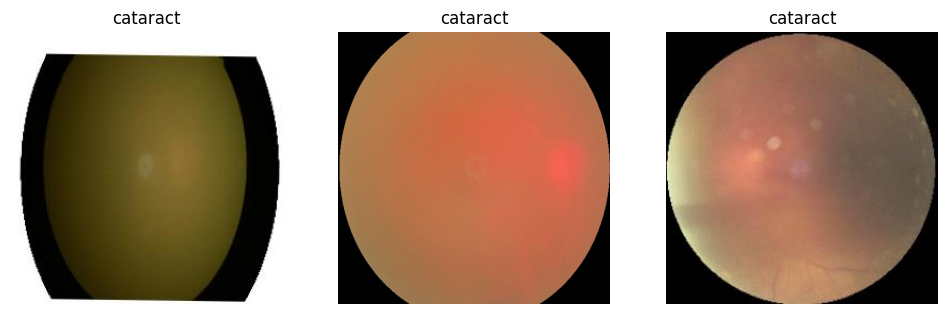

In [ ]:
plot_image(1)


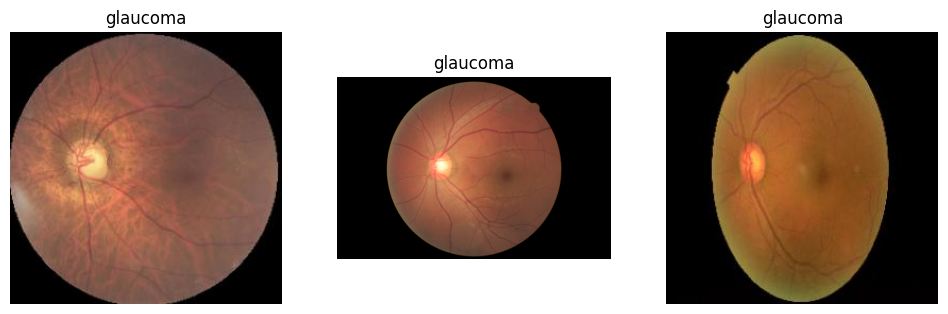

In [ ]:
plot_image(0)


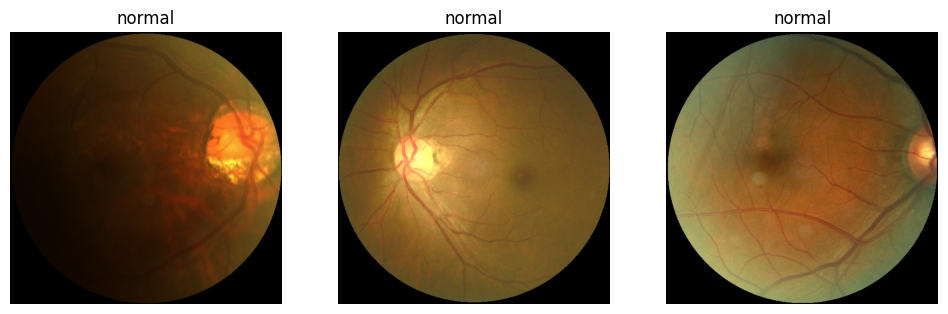

In [ ]:
plot_image(2)


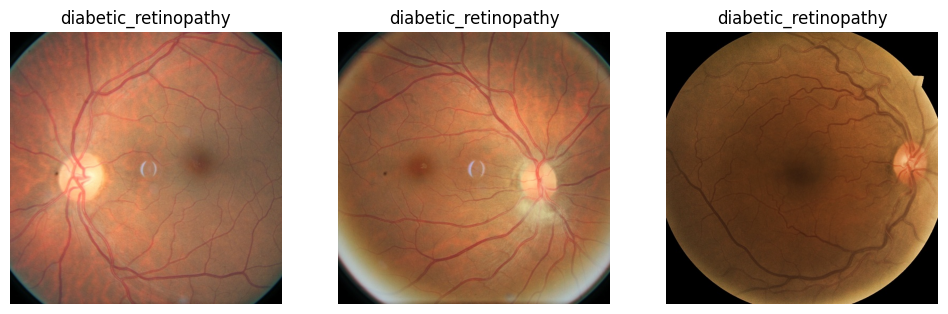

In [ ]:
plot_image(3)


In [ ]:
# map the labels to the disease type
df['disease_type'] = df['disease_type'].map({0:'glaucoma',1:'cataract',2:'normal',3:'diabetic_retinopathy'})

In [ ]:
# check the lebel count to verify it has been mapped
df.disease_type.value_counts()

diabetic_retinopathy    1108
normal                  1074
cataract                1038
glaucoma                1017
Name: disease_type, dtype: int64

In [ ]:
# randomising the dataset
df1 = df.sample(frac=1).reset_index(drop=True)

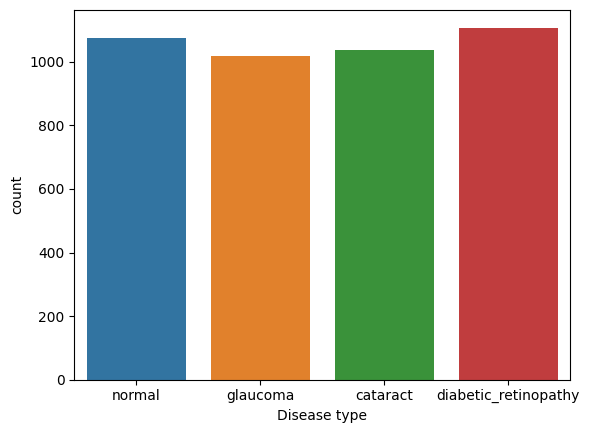

In [ ]:
# create a countplot of the disease type
sns.countplot(x = 'disease_type', data = df1)
plt.xlabel("Disease type")
plt.show()


In [ ]:
#import necessary libraries for the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# augumentation of images
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [ ]:
# create the train data
train_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = True,
                                          subset = 'training')

Found 3390 validated image filenames belonging to 4 classes.


In [ ]:
# create the validation data
valid_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = False,
                                          subset = 'validation')

Found 847 validated image filenames belonging to 4 classes.


In [ ]:
labels=[key for key in train_data.class_indices]
num_classes = len(disease_type)

model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(224,224, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

In [ ]:
# fitting the model
his = model.fit(
  train_data,
    validation_data=valid_data,
  epochs=10
)

Epoch 1/10
106/106 [==============================] - 196s 2s/step - loss: 0.1178 - accuracy: 0.9581 - val_loss: 0.4427 - val_accuracy: 0.8678
Epoch 2/10
106/106 [==============================] - 200s 2s/step - loss: 0.1244 - accuracy: 0.9569 - val_loss: 0.4628 - val_accuracy: 0.8489
Epoch 3/10
106/106 [==============================] - 205s 2s/step - loss: 0.0898 - accuracy: 0.9690 - val_loss: 0.4530 - val_accuracy: 0.8689
Epoch 4/10
106/106 [==============================] - 198s 2s/step - loss: 0.0644 - accuracy: 0.9785 - val_loss: 0.4427 - val_accuracy: 0.8749
Epoch 5/10
106/106 [==============================] - 199s 2s/step - loss: 0.0543 - accuracy: 0.9847 - val_loss: 0.5070 - val_accuracy: 0.8666
Epoch 6/10
106/106 [==============================] - 193s 2s/step - loss: 0.0516 - accuracy: 0.9838 - val_loss: 0.5847 - val_accuracy: 0.8666
Epoch 7/10
106/106 [==============================] - 199s 2s/step - loss: 0.0613 - accuracy: 0.9794 - val_loss: 0.5175 - val_accuracy: 0.8808

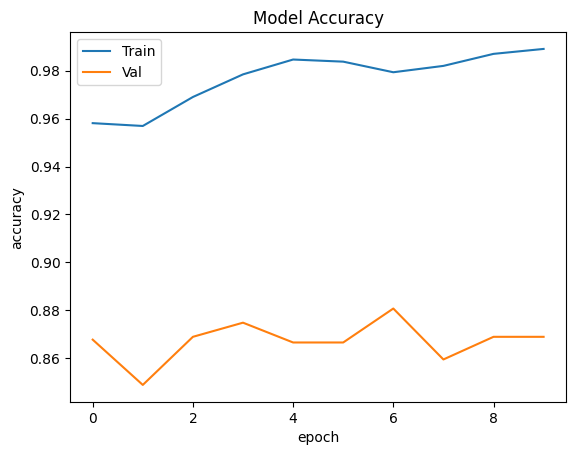

In [ ]:
    # create a plot of accuracy and val_acuracy for each epoch
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

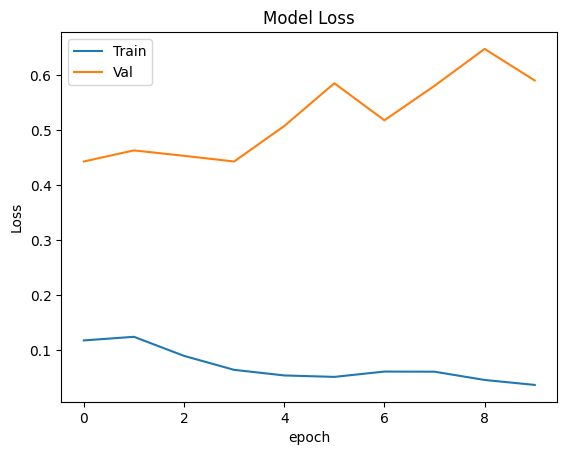

In [ ]:
# create a plot of loss and val_loss for each epoch
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

In [ ]:
# evaluate the model
y_test = valid_data.classes
y_pred = model.predict(valid_data)
y_pred = np.argmax(y_pred,axis=1)

27/27 [==============================] - 18s 657ms/step


In [ ]:
# generate classification report of the model
print(classification_report(y_test,y_pred,target_names = labels))

                      precision    recall  f1-score   support

            cataract       0.89      0.85      0.87       196
diabetic_retinopathy       0.98      1.00      0.99       232
            glaucoma       0.80      0.76      0.78       202
              normal       0.79      0.85      0.82       217

            accuracy                           0.87       847
           macro avg       0.87      0.86      0.86       847
        weighted avg       0.87      0.87      0.87       847



In [ ]:
model.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
